In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from pathlib import Path

json_file = Path('prod_snapshot/schemes-prod-firestore-structure.json')
output_dir = Path('figures')

In [5]:
with open(json_file, 'rb') as f:
    data = json.load(f)

    schemes = data['schemes']['documents']
    user_queries = data['userQuery']['documents']
    chat_history = data['chatHistory']['documents']

In [ ]:
user_queries[0]

In [6]:
from collections import Counter

scheme_type = Counter()
scheme_count = Counter()
agency_count = Counter()

def get_keys(new: bool) -> tuple[str, str, str]:
    return ('scheme', 'scheme_type', 'agency') if new else ('Scheme', 'Scheme Type', 'Agency')

for query in user_queries:
    for scheme in query['data']['schemes_response']:
        scheme_name_key, scheme_type_key, scheme_agency_key = get_keys('scheme' in scheme)
        scheme_count[scheme[scheme_name_key]] += 1

        scheme_types = [x.lower().strip() for x in scheme[scheme_type_key].split(',')] if isinstance(scheme[scheme_type_key], str) else []
        for scheme_type_cat in scheme_types:
            scheme_type[scheme_type_cat] += 1

        agency_count[scheme[scheme_agency_key]] += 1

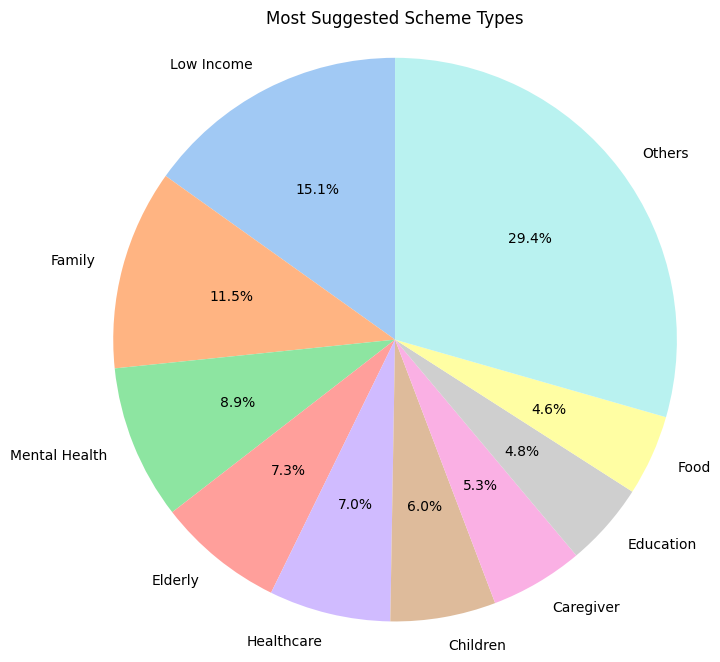

In [7]:
TOP_N = 9

sorted_cats = sorted(scheme_type.items(), key = lambda x: x[1], reverse=True)

topn = sorted_cats[:TOP_N]
sum_others = sum([x[1] for x in sorted_cats[TOP_N:]])

labels = [x[0].title() for x in topn] + ['Others']
sizes = [x[1] for x in topn] + [sum_others]

colors = sns.color_palette('pastel')

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Most Suggested Scheme Types')

fig_fp = output_dir / 'types_piechart.jpg'
plt.savefig(fig_fp)
plt.show()

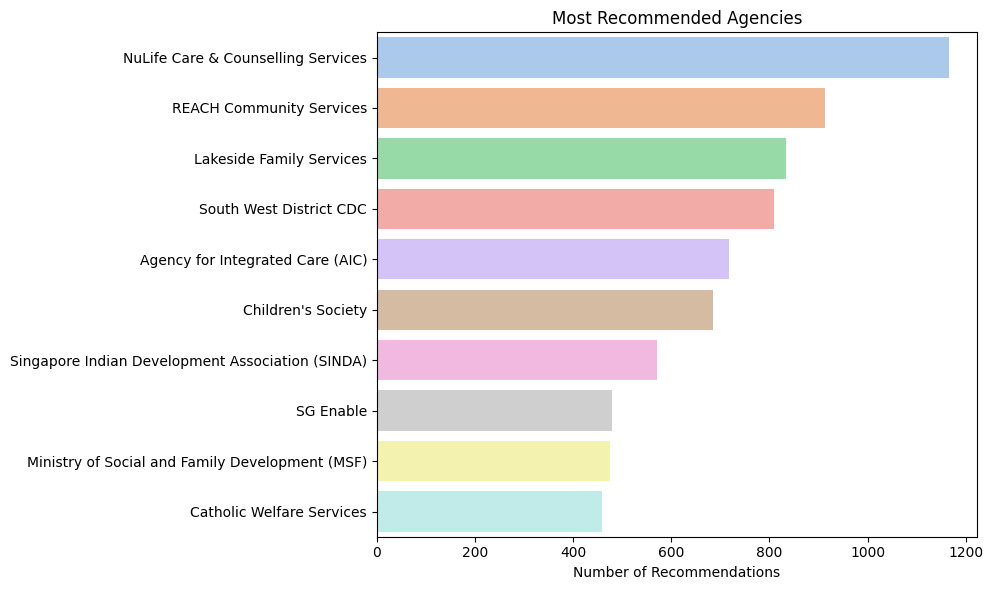

In [8]:
TOP_N = 10

num_queries = len(user_queries)
sorted_agencies = sorted(agency_count.items(), reverse=True, key=lambda x: x[1])[:TOP_N]

barplot_data = {
    "Agencies": [x[0] for x in sorted_agencies],
    "Recommendations": [x[1] for x in sorted_agencies]
}

plt.figure(figsize=(10, 6))

ax = sns.barplot(y=barplot_data["Agencies"], x=barplot_data["Recommendations"], hue=barplot_data["Agencies"], orient='y', palette=sns.color_palette('pastel'))

ax.set_title('Most Recommended Agencies')
ax.set_xlabel('Number of Recommendations')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(
    ax.get_yticklabels(),
    ha='right',
    fontsize=10
)

plt.tight_layout()

fig_fp = output_dir / 'agencies.jpg'
plt.savefig(fig_fp)
plt.show()

In [11]:
print(f"No. of User Queries:\t{len(user_queries)}")
print(f"No. of Chat Sessions:\t{len(chat_history)}")

No. of User Queries:	1270
No. of Chat Sessions:	314


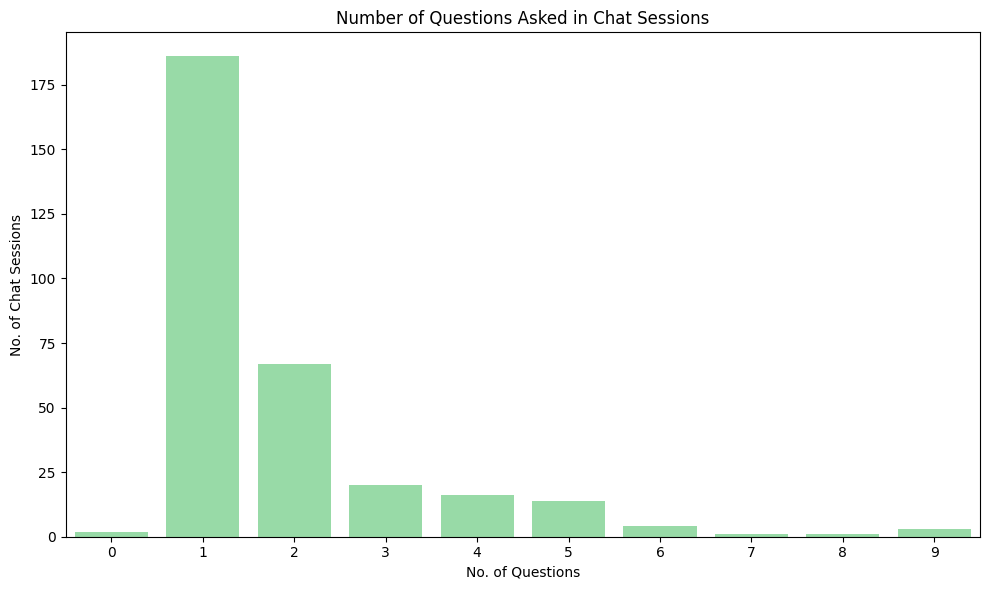

In [26]:
num_messages = [len(chat_session['data']['messages']) for chat_session in chat_history]
num_questions = sorted([(num-1)//2 for num in num_messages])


plt.figure(figsize=(10, 6))

ax = sns.countplot(x=num_questions, color=sns.color_palette('pastel')[2])

ax.set_title('Number of Questions Asked in Chat Sessions')
ax.set_xlabel('No. of Questions')
ax.set_ylabel('No. of Chat Sessions')

plt.tight_layout()

fig_fp = output_dir / 'num_questions.jpg'
plt.savefig(fig_fp)
plt.show()

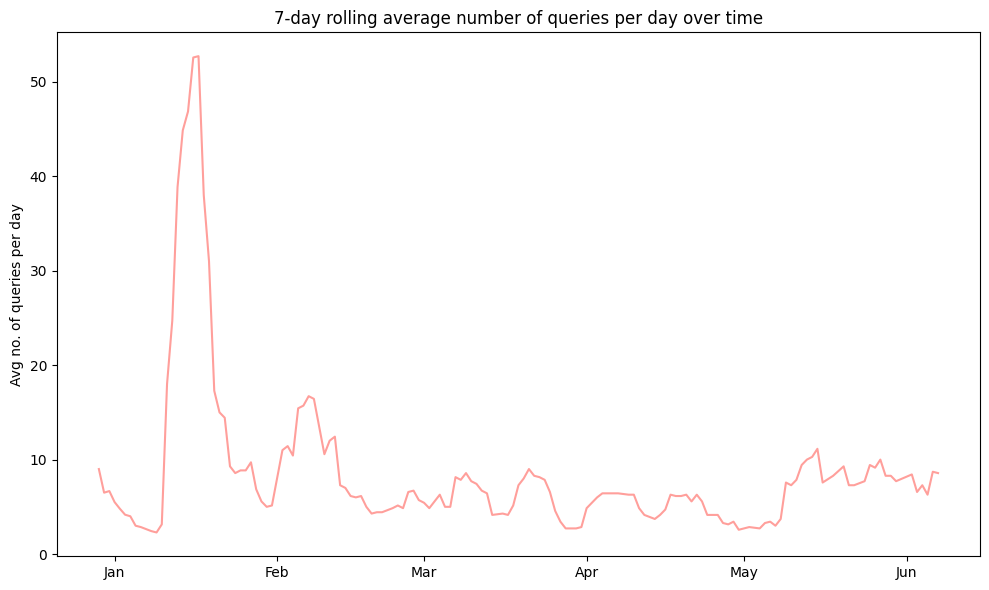

In [80]:
from datetime import datetime
import matplotlib.dates as mdates

format_str = "%a, %d %b %Y %H:%M:%S %Z"

dates = [datetime.strptime(query['data']['query_timestamp'], format_str) for query in user_queries if query['data']['query_timestamp']]
dates_df = pd.DataFrame({'timestamps': dates})
grouped = dates_df.groupby(dates_df['timestamps'].dt.date).agg(count=('timestamps', 'count'))
grouped['rolling'] = grouped['count'].rolling(window=7, min_periods = 1).mean()
grouped['date'] = pd.to_datetime(grouped.index)

plt.figure(figsize=(10, 6))

ax = sns.lineplot(data = grouped, x='date', y='rolling', color=sns.color_palette('pastel')[3])

ax.set_title('7-day rolling average number of queries per day over time')
ax.set_ylabel('Avg no. of queries per day')
ax.set_xlabel(None)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()

fig_fp = output_dir / 'num_queries_over_time.jpg'
plt.savefig(fig_fp)
plt.show()

,dates
0,2025-02-20 13:24:23
1,2025-04-22 00:37:41
2,2025-01-25 13:48:04
3,2025-05-24 14:54:32
4,2025-01-13 06:24:10
...,...
1264,2025-01-13 12:07:45
1265,2025-03-07 15:58:23
1266,2025-01-20 07:05:58
1267,2025-02-13 04:50:08
